In [1]:
from DeepClassifier import DeepClassifier, create_classifier
from tensorflow.keras import optimizers
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings("ignore", category=DeprecationWarning)


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

df = pd.read_csv('credit_risk_dataset.csv')

df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [2]:
df["loan_status"].value_counts()

0    25473
1     7108
Name: loan_status, dtype: int64

In [3]:
print(f"{int(100*df[df['loan_status']==1].shape[0] / df.shape[0])}% of Rows are Defaults")

21% of Rows are Defaults


The dataset is imbalanced at almost 1:5 ratio, therefore the defaults are the least frequent class and the most important one.

Model performance will be assessed on Macro Averaged F1 Score, that shows robustness in this kind of scenario.

# Impute NaN and Drop Duplicates

In [4]:
df["person_emp_length"].fillna(df["person_emp_length"].median(), inplace=True)

df["loan_int_rate"].fillna(df["loan_int_rate"].median(), inplace=True)

df.drop_duplicates(inplace=True)

df[df.isnull().any(axis=1)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length


In [5]:
categorical_columns = df.columns[df.dtypes == 'object']

categorical_columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [6]:
for column in categorical_columns:
    df = pd.concat([df.drop(columns=[column]), pd.get_dummies(df[column], prefix=column, drop_first=True)],axis=1)

df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,0,0,...,0,1,0,0,0,1,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,2,0,1,...,0,0,0,1,0,0,0,0,0,0
2,25,9600,1.0,5500,12.87,1,0.57,3,0,0,...,1,0,0,0,1,0,0,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,1,0,0,0,1,0,0,0,0,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,0,0,...,0,1,0,0,1,0,0,0,0,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,0,0,...,0,1,0,0,0,0,0,0,0,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,...,0,0,0,1,0,0,0,0,0,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,0,0,...,0,1,0,1,0,0,0,0,0,0


In [7]:
X = df.drop(columns=['loan_status', 'loan_percent_income'])

Y = df['loan_status']

numerical_columns = X.columns[X.dtypes != 'uint8']

In [8]:
X.loc[:,numerical_columns]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
0,22,59000,123.0,35000,16.02,3
1,21,9600,5.0,1000,11.14,2
2,25,9600,1.0,5500,12.87,3
3,23,65500,4.0,35000,15.23,2
4,24,54400,8.0,35000,14.27,4
...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,30
32577,54,120000,4.0,17625,7.49,19
32578,65,76000,3.0,35000,10.99,28
32579,56,150000,5.0,15000,11.48,26


In [9]:
# MinMax Scaler preservers One Hot Encoded variables
scaler = StandardScaler().fit(X.loc[:,numerical_columns])

In [10]:
X.loc[:,numerical_columns] = scaler.transform(X.loc[:,numerical_columns])

In [11]:
X

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,-0.904471,-0.114354,28.904903,4.018287,1.623527,-0.692614,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,-1.061852,-0.910941,0.056504,-1.359219,0.040655,-0.938982,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,-0.432327,-0.910941,-0.921408,-0.647491,0.601796,-0.692614,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,-0.747089,-0.009540,-0.187974,4.018287,1.367283,-0.938982,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
4,-0.589708,-0.188530,0.789938,4.018287,1.055898,-0.446246,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,4.603869,-0.211106,-0.921408,-0.600042,0.695860,5.959324,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
32577,4.131726,0.869285,-0.187974,1.270223,-1.143256,3.249275,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
32578,5.862918,0.159775,-0.432452,4.018287,-0.007999,5.466588,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
32579,4.446488,1.353041,0.056504,0.855048,0.150937,4.973852,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [12]:
classifcator = DeepClassifier(
    model=create_classifier,
    loss="binary_crossentropy",
    model__architecture={
        "Layers": ["Dense", "Dense"],
        "ActivationFunctions": ["relu", "sigmoid"],
        "Neurons": [50, 1],
    },
    callbacks=EarlyStopping,
    callbacks__monitor="val_loss",
    callbacks__min_delta=0.00001,
    callbacks__patience=20,
    callbacks__verbose=0,
    callbacks__restore_best_weights=True,
    verbose=0,
    epochs=200,
    train_ratio=0.8,
    val_ratio=0.2,
    batch_size_custom=32*8,
    fit__shuffle=True,
    optimizer=optimizers.Adam,
    balance_class_weights=False,
)


param_grid = {
    "balance_class_weights": [True, False],
    "optimizer__learning_rate": [0.00001, 0.0001, 0.001],
    "loss":["binary_crossentropy"],
    "model__architecture": [
        {
            "Layers": ["Dense", "Dense"],
            "ActivationFunctions": ["relu", "sigmoid"],
            "Neurons": [50, 1],
        },
        {
            "Layers": ["Dense", "Dense"],
            "ActivationFunctions": ["relu", "sigmoid"],
            "Neurons": [100, 1],
        },
        {
            "Layers": ["Dense", "Dense", "Dense"],
            "ActivationFunctions": ["relu", "relu", "sigmoid"],
            "Neurons": [100, 50, 1],
        },
        {
            "Layers": ["Dense", "Dense", "Dense", "Dense"],
            "ActivationFunctions": ["relu", "relu", "relu", "sigmoid"],
            "Neurons": [200, 100, 50, 1],
        },
    ],
}

clf = GridSearchCV(
    refit=True,
    estimator=classifcator,
    param_grid=param_grid,
    # Train all the models in paralel
    n_jobs=-1,
    cv=3,
    verbose=10,
    scoring='f1_macro',
)

# 80% train / 20% test
# Train set will be splitted again in order to use 20% of it for Keras validation

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

clf.fit(X_train, y_train)

grid_search_cv = (
    pd.DataFrame.from_dict(clf.cv_results_)
    .sort_values(by=["rank_test_score"], ascending=True)
    .head(100)
)

grid_search_cv.index = grid_search_cv.rank_test_score
grid_search_cv.to_csv("GridSearchResults.csv")


pd.read_csv('GridSearchResults.csv')

Fitting 3 folds for each of 24 candidates, totalling 72 fits


,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_balance_class_weights,param_loss,param_model__architecture,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score.1
0,1,30.771431,3.126967,0.624691,0.055436,False,binary_crossentropy,"{'Layers': ['Dense', 'Dense', 'Dense'], 'Activ...",0.00100,"{'balance_class_weights': False, 'loss': 'bina...",0.861804,0.858717,0.865252,0.861924,0.002669,1
1,2,59.894262,1.657648,0.539315,0.047409,False,binary_crossentropy,"{'Layers': ['Dense', 'Dense'], 'ActivationFunc...",0.00100,"{'balance_class_weights': False, 'loss': 'bina...",0.863100,0.856973,0.862337,0.860803,0.002726,2
2,3,30.741990,0.555233,0.594815,0.240988,False,binary_crossentropy,"{'Layers': ['Dense', 'Dense', 'Dense', 'Dense'...",0.00100,"{'balance_class_weights': False, 'loss': 'bina...",0.862907,0.853802,0.860648,0.859119,0.003871,3
3,4,63.450272,5.239256,0.395234,0.029870,False,binary_crossentropy,"{'Layers': ['Dense', 'Dense'], 'ActivationFunc...",0.00100,"{'balance_class_weights': False, 'loss': 'bina...",0.861043,0.855195,0.859711,0.858650,0.002503,4
4,5,76.180144,0.637071,3.400374,4.528053,False,binary_crossentropy,"{'Layers': ['Dense', 'Dense', 'Dense', 'Dense'...",0.00010,"{'balance_class_weights': False, 'loss': 'bina...",0.861412,0.853759,0.855146,0.856772,0.003329,5
5,6,86.837944,2.065761,0.949954,0.191928,False,binary_crossentropy,"{'Layers': ['Dense', 'Dense', 'Dense'], 'Activ...",0.00010,"{'balance_class_weights': False, 'loss': 'bina...",0.856276,0.848964,0.852245,0.852495,0.002991,6
6,7,27.050798,4.026050,0.872837,0.144092,True,binary_crossentropy,"{'Layers': ['Dense', 'Dense', 'Dense', 'Dense'...",0.00100,"{'balance_class_weights': True, 'loss': 'binar...",0.847455,0.840993,0.850400,0.846283,0.003929,7
7,8,29.946195,0.877627,0.572509,0.130600,True,binary_crossentropy,"{'Layers': ['Dense', 'Dense', 'Dense'], 'Activ...",0.00100,"{'balance_class_weights': True, 'loss': 'binar...",0.849224,0.837873,0.842243,0.843113,0.004675,8
8,9,57.921780,0.393627,0.538580,0.057361,False,binary_crossentropy,"{'Layers': ['Dense', 'Dense'], 'ActivationFunc...",0.00010,"{'balance_class_weights': False, 'loss': 'bina...",0.837087,0.827060,0.823602,0.829250,0.005719,9
9,10,61.726776,16.458564,0.740241,0.171855,True,binary_crossentropy,"{'Layers': ['Dense', 'Dense', 'Dense', 'Dense'...",0.00010,"{'balance_class_weights': True, 'loss': 'binar...",0.810208,0.825296,0.836201,0.823902,0.010657,10


In [13]:
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

y_pred = clf.best_estimator_.predict(X_test)

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"True Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive: {tp}")

print("\n")

print(classification_report(y_test, y_pred, target_names = ['Non-Default', 'Default']))

True Negative: 4972
False Positive: 83
False Negative: 422
True Positive: 1007


              precision    recall  f1-score   support

 Non-Default       0.92      0.98      0.95      5055
     Default       0.92      0.70      0.80      1429

    accuracy                           0.92      6484
   macro avg       0.92      0.84      0.88      6484
weighted avg       0.92      0.92      0.92      6484



In [15]:
print('Best Estimator')
print('-'*90)
print(clf.best_estimator_)
print('-'*90)

Best Estimator
------------------------------------------------------------------------------------------
DeepClassifier(
	model=<function create_classifier at 0x7fbea0c86d30>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<class 'keras.optimizer_v2.adam.Adam'>
	loss=binary_crossentropy
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=<class 'keras.callbacks.EarlyStopping'>
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
	model__architecture={'Layers': ['Dense', 'Dense', 'Dense'], 'ActivationFunctions': ['relu', 'relu', 'sigmoid'], 'Neurons': [100, 50, 1]}
	callbacks__monitor=val_loss
	callbacks__min_delta=1e-05
	callbacks__patience=20
	callbacks__verbose=0
	callbacks__restore_best_weights=True
	train_ratio=0.8
	val_ratio=0.2
	batch_size_custom=256
	fit__shuffle=True
	balance_class_weights=False
	optimizer__learning_rate=0.001
	class_weight=None
)
-------------------------------------------------------------------------

In [16]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))

In [17]:
from sklearn.metrics import f1_score
import numpy as np
import shap
import warnings
warnings.filterwarnings('ignore') 




def f(X):
    X = X.reshape((X.shape[0], X.shape[1], 1))
    results = clf.best_estimator_.predict(X).flatten()
    return results

In [18]:
explainer = shap.KernelExplainer(f, X_test[:100,:])
shap_values = explainer.shap_values(X_test[300:350,:], nsamples=500)



  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
plot = shap.force_plot(explainer.expected_value, shap_values, pd.DataFrame(X_test[300:350,:], columns=X.columns), matplotlib=False,show=False)

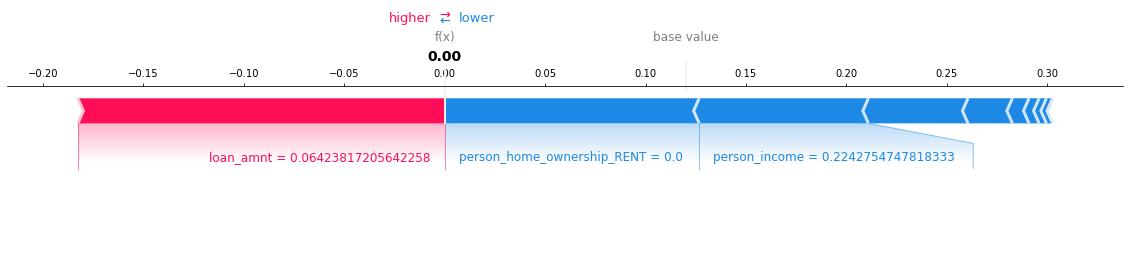

In [23]:
plot

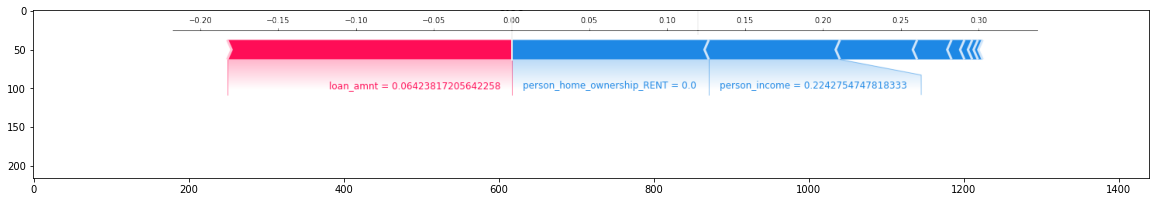

In [21]:
plot = shap.force_plot(explainer.expected_value, shap_values[0], pd.DataFrame(X_test[1300:1301,:], columns=X.columns), matplotlib=True, show=False)
plt.savefig('uni_row_plot.png')
plt.close()
plt.figure(figsize = (20,4))
img = mpimg.imread('uni_row_plot.png')
plt.imshow(img)
plt.show()
